<a href="https://colab.research.google.com/github/Amitle51/understat_analysis_project/blob/main/understat_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understat Football Match Analysis

## Objectives

In this analysis of Understat football match data, the goals are to:

*TBC*

## Data Loading and Description

In [4]:
import pandas as pd
df = pd.read_csv('/content/understat_per_game.csv')

In [5]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 league          0
year            0
h_a             0
xG              0
xGA             0
npxG            0
npxGA           0
deep            0
deep_allowed    0
scored          0
missed          0
xpts            0
result          0
date            0
wins            0
draws           0
loses           0
pts             0
npxGD           0
ppda_coef       0
ppda_att        0
ppda_def        0
oppda_coef      0
oppda_att       0
oppda_def       0
team            0
xG_diff         0
xGA_diff        0
xpts_diff       0
dtype: int64


In [ ]:
print("Duplicate Rows:", df.duplicated().sum())

In [6]:
df = df.astype({
    'league': 'category',
    'year': 'category',
    'team': 'category',
    'h_a': 'category',
    'result': 'category',
    'pts': 'category',
    'team': 'category'
})

In [7]:
print(df.dtypes)

league          category
year            category
h_a             category
xG               float64
xGA              float64
npxG             float64
npxGA            float64
deep               int64
deep_allowed       int64
scored             int64
missed             int64
xpts             float64
result          category
date              object
wins               int64
draws              int64
loses              int64
pts             category
npxGD            float64
ppda_coef        float64
ppda_att           int64
ppda_def           int64
oppda_coef       float64
oppda_att          int64
oppda_def          int64
team            category
xG_diff          float64
xGA_diff         float64
xpts_diff        float64
dtype: object


In [ ]:
df.describe()

## EDA

### Correlations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = df.select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix for numerical variables only
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))  # Increase the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})  # Adjust font size
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

### Distributions

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).drop(['wins', 'draws', 'loses', 'xGA', 'npxGA', 'deep_allowed', 'missed', 'xGA_diff', 'oppda_coef', 'oppda_def', 'oppda_att'], axis=1).columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i)  # Adjust layout for readability
    sns.kdeplot(df[column], fill=True)  # Replaced shade=True with fill=True
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Looking at the distributions per yer:

In [ ]:
years = df['year'].unique()

plt.figure(figsize=(15, 10))

# Loop through each numerical column and create a subplot
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i)

    # Loop through each year and plot its density for the current column
    for year in years:
        sns.kdeplot(df[df['year'] == year][column], fill=False, label=str(year), alpha=1)

    # Set title and labels
    plt.title(f'Density Plot of {column} by Year')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend(title='Year')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### And per league:

In [ ]:
leagues = df['league'].unique()

plt.figure(figsize=(15, 10))

# Loop through each numerical column and create a subplot
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i)

    # Loop through each league and plot its density for the current column
    for league in leagues:
        sns.kdeplot(df[df['league'] == league][column], fill=False, label=str(league), alpha=1)

    # Set title and labels
    plt.title(f'Density Plot of {column} by league')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend(title='League')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Pre Processing

## Clustering

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

agg_features = df.groupby(['league', 'year']).agg({
    'xG': 'mean',
    # 'xGA': 'mean',
    'deep': 'mean',
    # 'deep_allowed': 'mean',
    'ppda_coef': 'mean',
    # 'oppda_coef': 'mean',
    'xG_diff': 'mean',
    # 'xGA_diff': 'mean',
    # Add other columns as needed
}).reset_index()

<ipython-input-22-d298801df32e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_features = df.groupby(['league', 'year']).agg({


In [23]:
# Splitting the aggregated data by year and storing each year's data as a separate DataFrame
yearly_data = {year: agg_features[agg_features['year'] == year].copy() for year in agg_features['year'].unique()}

# Selecting data for one specific year (e.g., 2020) for scaling and clustering
df_selected_year = yearly_data[2014]  # Replace 2020 with the year of interest

# Scaling the selected year's data (excluding 'league' and 'year' columns)
from sklearn.preprocessing import StandardScaler

columns_to_scale = df_selected_year.columns.difference(['league', 'year'])
scaler = StandardScaler()
df_selected_year[columns_to_scale] = scaler.fit_transform(df_selected_year[columns_to_scale])

In [ ]:
df_selected_year

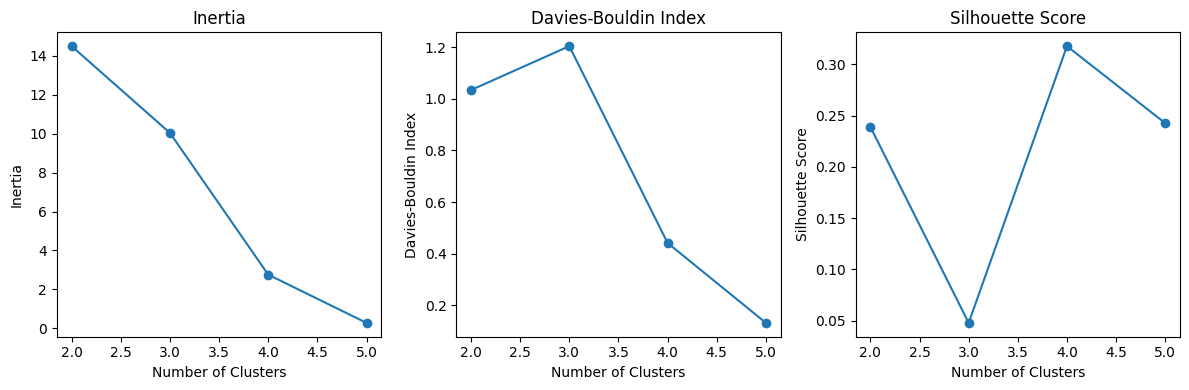

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Define the range of clusters to evaluate (1 to 5)
cluster_range = range(2, 6)  # Start from 2 because silhouette and DBI are undefined for 1 cluster

# Lists to store the evaluation metrics
inertia = []
davies_bouldin = []
silhouette = []

# Calculate metrics for each number of clusters
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=0)
    labels = kmeans.fit_predict(df_selected_year[columns_to_scale])

    # Inertia
    inertia.append(kmeans.inertia_)

    # Davies-Bouldin Index
    db_index = davies_bouldin_score(df_selected_year[columns_to_scale], labels)
    davies_bouldin.append(db_index)

    # Silhouette Score
    sil_score = silhouette_score(df_selected_year[columns_to_scale], labels)
    silhouette.append(sil_score)

# Plotting the results
plt.figure(figsize=(12, 4))

# Inertia plot
plt.subplot(1, 3, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia')

# Davies-Bouldin Index plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, davies_bouldin, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

# Silhouette Score plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


In [30]:
# Fit KMeans with the optimal number of clusters (4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
df_selected_year['playing_style_cluster'] = kmeans.fit_predict(df_selected_year[columns_to_scale])

# Display the clustered data with labels
df_selected_year.head(6)


,league,year,xG,deep,ppda_coef,xG_diff,playing_style_cluster
0,Bundesliga,2014,0.948535,0.267362,0.131868,-1.019128,3
6,EPL,2014,0.273157,1.402666,1.741395,1.555260,2
12,La_liga,2014,0.905059,-0.659689,-1.273178,1.223268,1
18,Ligue_1,2014,-1.131542,-1.726838,0.242975,-0.679660,0
24,RFPL,2014,-1.600085,-0.020699,-1.097829,-0.514327,0
30,Serie_A,2014,0.604877,0.737197,0.254769,-0.565412,3


By team

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

agg_features = df.groupby(['team', 'year']).agg({
    'xG': 'mean',
    'xGA': 'mean',
    'deep': 'mean',
    'deep_allowed': 'mean',
    'ppda_coef': 'mean',
    'oppda_coef': 'mean',
    'xG_diff': 'mean',
    'xGA_diff': 'mean',
    # Add other columns as needed
}).reset_index()
agg_features = agg_features.dropna().reset_index(drop=True)

<ipython-input-48-be12822325b9>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_features = df.groupby(['team', 'year']).agg({


In [49]:
# Splitting the aggregated data by year and storing each year's data as a separate DataFrame
yearly_data = {year: agg_features[agg_features['year'] == year].copy() for year in agg_features['year'].unique()}

# Selecting data for one specific year (e.g., 2020) for scaling and clustering
df_selected_year = yearly_data[2019]  # Replace 2020 with the year of interest

# Scaling the selected year's data (excluding 'league' and 'year' columns)
from sklearn.preprocessing import StandardScaler

columns_to_scale = df_selected_year.columns.difference(['team', 'year'])
scaler = StandardScaler()
df_selected_year[columns_to_scale] = scaler.fit_transform(df_selected_year[columns_to_scale])

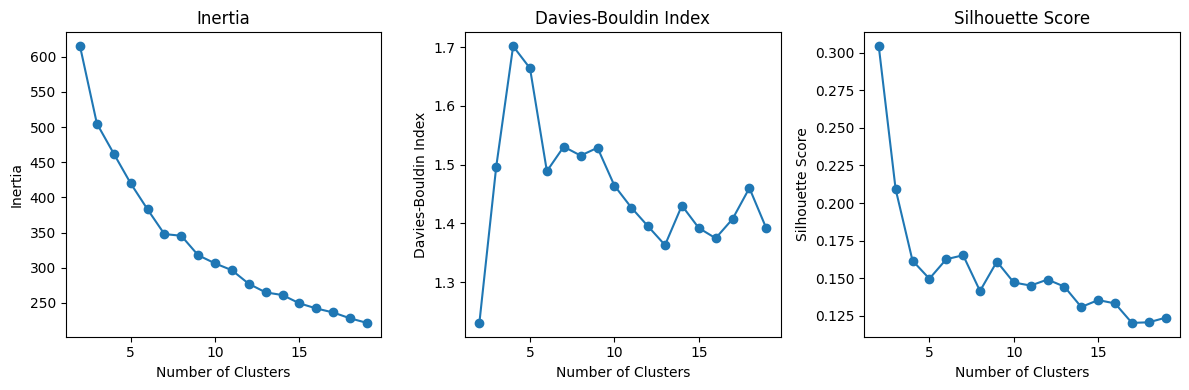

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Define the range of clusters to evaluate (1 to 5)
cluster_range = range(2, 20)  # Start from 2 because silhouette and DBI are undefined for 1 cluster

# Lists to store the evaluation metrics
inertia = []
davies_bouldin = []
silhouette = []

# Calculate metrics for each number of clusters
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=0)
    labels = kmeans.fit_predict(df_selected_year[columns_to_scale])

    # Inertia
    inertia.append(kmeans.inertia_)

    # Davies-Bouldin Index
    db_index = davies_bouldin_score(df_selected_year[columns_to_scale], labels)
    davies_bouldin.append(db_index)

    # Silhouette Score
    sil_score = silhouette_score(df_selected_year[columns_to_scale], labels)
    silhouette.append(sil_score)

# Plotting the results
plt.figure(figsize=(12, 4))

# Inertia plot
plt.subplot(1, 3, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia')

# Davies-Bouldin Index plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, davies_bouldin, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

# Silhouette Score plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


In [51]:
# Fit KMeans with the optimal number of clusters (4)
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
df_selected_year['playing_style_cluster'] = kmeans.fit_predict(df_selected_year[columns_to_scale])

# Display the clustered data with labels
df_selected_year_sorted = df_selected_year.sort_values(by='playing_style_cluster').reset_index(drop=True)
df_selected_year_sorted.head(30)

,team,year,xG,xGA,deep,deep_allowed,ppda_coef,oppda_coef,xG_diff,xGA_diff,playing_style_cluster
0,Augsburg,2019,-0.223775,1.221238,-0.898628,0.417472,1.974759,-1.043916,-0.243993,-0.662270,0
1,Bournemouth,2019,-0.514819,0.973591,-0.172662,1.719955,0.964917,-0.644374,0.618096,-0.294312,0
2,Toulouse,2019,-0.662221,1.171495,-0.810779,0.287438,0.883081,-0.492155,1.769017,-1.901259,0
3,Mainz 05,2019,-0.049098,1.597421,-0.263843,0.777776,0.599725,-0.895525,0.295855,-0.384305,0
4,Mallorca,2019,-0.797139,1.140692,-1.107440,1.431512,0.374778,-1.284944,0.007338,-0.032004,0
5,Fortuna Duesseldorf,2019,-0.835109,1.751741,-0.766381,0.114058,1.977289,-0.014265,-0.108901,-0.454612,0
6,Watford,2019,-0.254145,0.638114,0.028493,0.583152,0.685640,-0.469440,1.761668,-0.681102,0
7,Brescia,2019,-0.610085,2.317512,-0.409314,2.551348,1.181203,-1.420064,1.136553,-0.142244,0
8,Lecce,2019,-0.009896,3.425633,-0.129809,2.287669,2.006598,-0.419715,0.214326,1.011479,0
9,Newcastle United,2019,-1.062702,1.306286,-1.095607,2.025365,3.981114,-1.209885,-0.277348,1.206717,0
